Mathematica code:


```
(*Define variables*)
Clear[g, t, S, delta]

(*Define S function*)
S[g_, gdot_] := (gdot^2)/(8*(Delta^2 + g^2)^2)

(*Partial derivatives*)
dSdg = D[S[g[t], g'[t]], g[t]]
dSdgd = D[S[g[t], g'[t]], g'[t]]

(*Total time derivative*)
dSdgdt = D[dSdgd, t]


(*Euler-Lagrange equation*)
eulerEq = dSdg - dSdgdt == 0

(*Solve differential equation*)
sol = DSolve[{eulerEq, {g[0] == g0, g[1] == -g0}}, g[t], t]

```



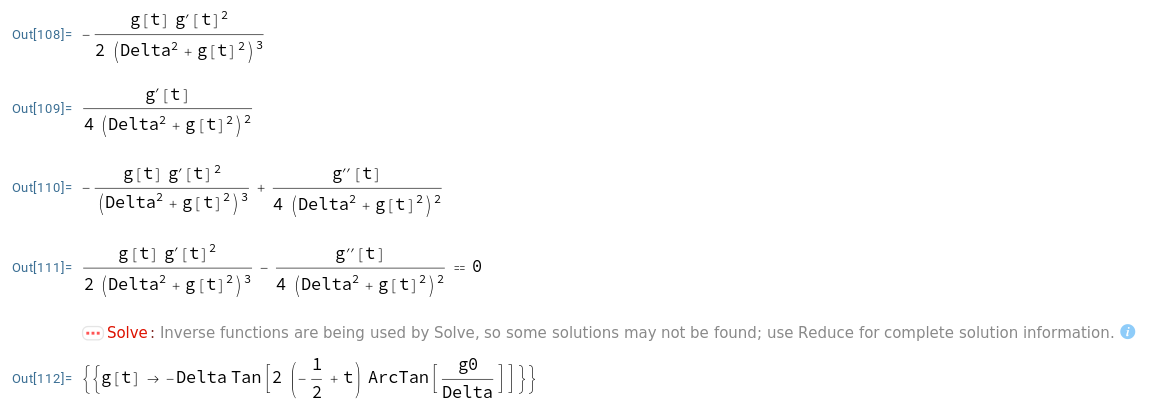

Solution:


```
{{g[t] -> -Delta Tan[2 (-(1/2) + t) ArcTan[g0/Delta]]}}
```



In [305]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [306]:
# Physical parameters
delta = 1 # Energy gap
alpha = -10 * delta
tau = 1.5 # total time evolution
omega_args = {'delta': delta, 'alpha': alpha, 'tau': tau}

temperature = 0.1 # Changes p_0
t_0 = 0
t_f = tau

# Formatting parameters
amt_times = 1000 # How many points we calculate
interval_colunas = 100 # Int interval between columns shown in work distr
width = depth = tau/100 # Size of the columns

# Fixed parameters
step = 1/amt_times

ts = np.linspace(t_0, t_f, amt_times)

In [307]:
def g_t(t: float, params_omega: dict):
  # Minimal action solution
  return -params_omega['delta'] * np.tan(((2 * t/params_omega['tau'] - 1))
                                         * np.arctan(params_omega['alpha']/params_omega['delta']))

In [308]:
Hstatic = delta * qutip.sigmax()
Hdinamic = qutip.sigmaz()
H_LZ = [Hstatic, [Hdinamic, g_t]]

def H_LZ_t(t:float, params_omega: dict):
  return Hstatic + Hdinamic * g_t(t, params_omega)

##Energy levels

In [309]:
gs_dyn = []
es_dyn = []
for i in ts:
  energies = H_LZ_t(i,omega_args).eigenenergies()
  gs_dyn += [energies[0]]
  es_dyn += [energies[1]]

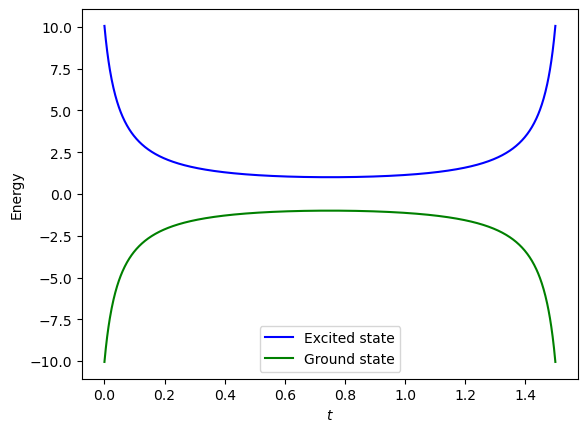

In [310]:
plt.plot(ts, es_dyn, color="blue", label="Excited state")
plt.plot(ts, gs_dyn, color="green", label="Ground state")

plt.legend()
plt.xlabel('$t$')
plt.ylabel('Energy')

plt.show()

## Work distribution

In [311]:
beta=1/temperature
n_beta = 1/(np.exp(-beta)-1)
rho_0 = qutip.thermal_dm(2, n_beta)
evol_total = qutip.propagator(H_LZ, ts,[],args=omega_args)

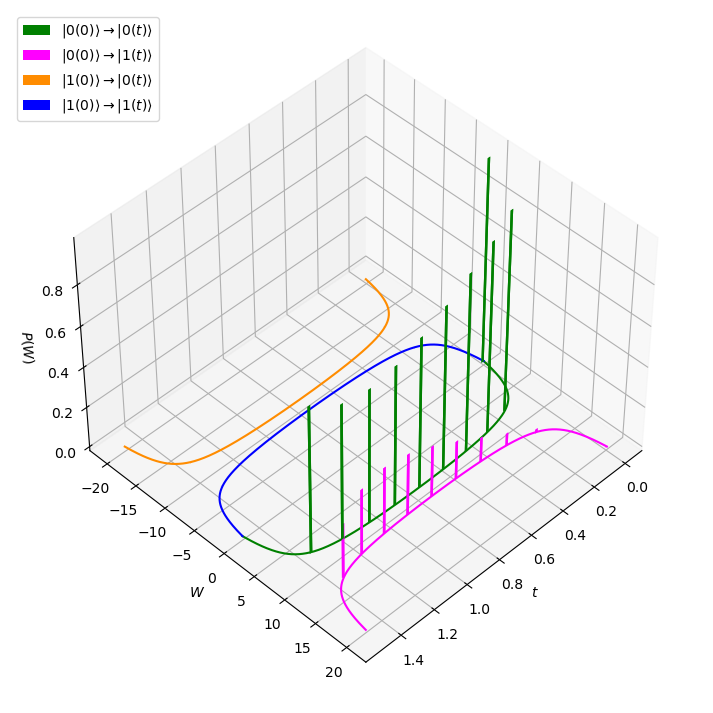

In [312]:
def p_n_m(t):
  ###return [p_00, p_01, p_10, p_11]
  conjaux_0 = np.array(H_LZ_t(0,omega_args).eigenstates()[1])
  conjaux_t = np.array(H_LZ_t(t,omega_args).eigenstates()[1])
  varaux = []
  for i in conjaux_t:
    for j in conjaux_0:
      varaux += [np.linalg.norm(np.linalg.multi_dot([i.dag().full(), evol_total[int(t * amt_times / tau)], j.full()]))**2]
  return varaux

points_00 = []
points_01 = []
points_10 = []
points_11 = []

for t in np.linspace(t_0, t_f - tau/amt_times, amt_times):
  #points = [energy_coord, prob]
  p0_gs = rho_0[1][0][1]
  p0_es = rho_0[0][0][0]
  p_nm = p_n_m(t)

  points_00 += [[gs_dyn[int(t * amt_times / tau)]-gs_dyn[0], p0_gs*p_nm[0]]]
  points_01 += [[es_dyn[int(t * amt_times / tau)]-gs_dyn[0], p0_gs*p_nm[1]]]
  points_10 += [[gs_dyn[int(t * amt_times / tau)]-es_dyn[0], p0_es*p_nm[0]]]
  points_11 += [[es_dyn[int(t * amt_times / tau)]-es_dyn[0], p0_es*p_nm[1]]]

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect(aspect=None, zoom=0.9)

# Adding points

for i in range(0, amt_times, interval_colunas):
    ax.bar3d(ts[i], points_00[i][0], 0, width, depth, points_00[i][1], color='green', shade=False)
    ax.bar3d(ts[i], points_01[i][0], 0, width, depth, points_01[i][1], color='fuchsia', shade=False)
    ax.bar3d(ts[i], points_10[i][0], 0, width, depth, points_10[i][1], color='darkorange', shade=False)
    ax.bar3d(ts[i], points_11[i][0], 0, width, depth, points_11[i][1], color='blue', shade=False)
    
# Axes label
ax.set_xlabel('$t$')
ax.set_ylabel('$W$')
ax.set_zlabel('$P(W)$')

# Legend
legend_elements = [Patch(facecolor='green', label='$ |0(0) \\rangle \\rightarrow |0(t) \\rangle $'),
                   Patch(facecolor='fuchsia', label='$ |0(0) \\rangle \\rightarrow |1(t) \\rangle $'),
                   Patch(facecolor='darkorange', label='$ |1(0) \\rangle \\rightarrow |0(t) \\rangle $'),
                   Patch(facecolor='blue', label='$ |1(0) \\rangle \\rightarrow |1(t) \\rangle $')]
ax.legend(handles=legend_elements, loc='upper left')

ax.plot(ts, gs_dyn-gs_dyn[0] , zs=0, zdir='z', color='green')
ax.plot(ts, es_dyn-es_dyn[0] , zs=0, zdir='z', color='blue')
ax.plot(ts, gs_dyn-es_dyn[0] , zs=0, zdir='z', color='darkorange')
ax.plot(ts, es_dyn-gs_dyn[0] , zs=0, zdir='z', color='fuchsia')

ax.view_init(45, 45) # View angle
plt.show()

## Probabilities vs. time

In [313]:
probs_00 = []
probs_01 = []
probs_10 = []
probs_11 = []

for i in range(amt_times):
    probs_00 += [points_00[i][1]]
    probs_01 += [points_01[i][1]]
    probs_10 += [points_10[i][1]]
    probs_11 += [points_11[i][1]]

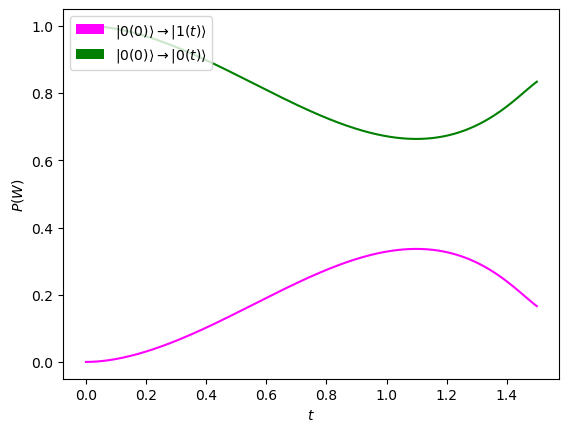

In [314]:
plt.figure()

# Axes label
plt.xlabel('$t$')
plt.ylabel('$P(W)$')

# Legend
legend_elements = [Patch(facecolor='fuchsia', label='$ |0(0) \\rangle \\rightarrow |1(t) \\rangle $'),
                   Patch(facecolor='green', label='$ |0(0) \\rangle \\rightarrow |0(t) \\rangle $')]
plt.legend(handles=legend_elements, loc='upper left')

plt.plot(ts, probs_00 , color='green')
plt.plot(ts, probs_01 , color='fuchsia')

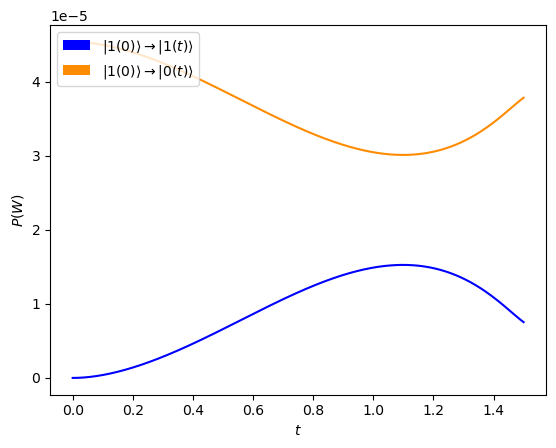

In [315]:
plt.figure()

# Axes label
plt.xlabel('$t$')
plt.ylabel('$P(W)$')

# Legend
legend_elements = [Patch(facecolor='blue', label='$ |1(0) \\rangle \\rightarrow |1(t) \\rangle$'),
                   Patch(facecolor='darkorange', label='$ |1(0) \\rangle \\rightarrow |0(t) \\rangle $')]
plt.legend(handles=legend_elements, loc='upper left')

plt.plot(ts, probs_11 , color='blue')
plt.plot(ts, probs_10 , color='darkorange')

Taking a look at $g(t)/\Delta$:

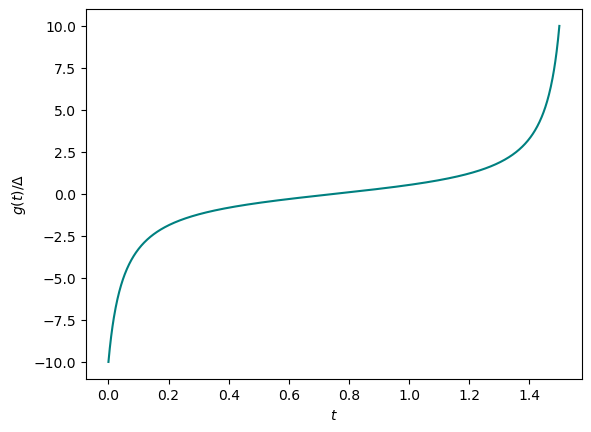

In [321]:
values = [g_t(i, omega_args)/delta for i in ts]

plt.figure()

# Axes label
plt.xlabel('$t$')
plt.ylabel('$g(t)/ \\Delta$')
plt.plot(ts, values, color='teal')
plt.show()

## Fidelity vs. $\tau$

In [317]:
t_f_fid = 20
t_0_fid = t_f_fid/amt_times
fidel_interval = np.linspace(t_0_fid,t_f_fid,amt_times)

In [318]:
def f_t(t: float, params_omega: dict):
    return params_omega['alpha'] + (params_omega['alpha2']-params_omega['alpha']) * t / params_omega['tau']

H_linear = [Hstatic, [Hdinamic, f_t]]

fidel = []
fidel_lin = []
for i in fidel_interval:
    gs_0 = H_LZ_t(0,{'delta': delta, 'alpha': alpha, 'tau': i}).eigenstates()[1][0]
    gs_t = H_LZ_t(i,{'delta': delta, 'alpha': alpha, 'tau': i}).eigenstates()[1][0]
    evol = qutip.propagator(H_LZ, [t_0, i],[],args={'delta': delta, 'alpha': alpha, 'tau': i})
    evol_lin = qutip.propagator(H_linear, [t_0, i],[],args={'alpha': alpha, 'alpha2': -alpha, 'tau': i})
    fidel += [np.linalg.norm(np.linalg.multi_dot([gs_t.dag(),evol,gs_0]))**2]
    fidel_lin += [np.linalg.norm(np.linalg.multi_dot([gs_t.dag(),evol_lin,gs_0]))**2]

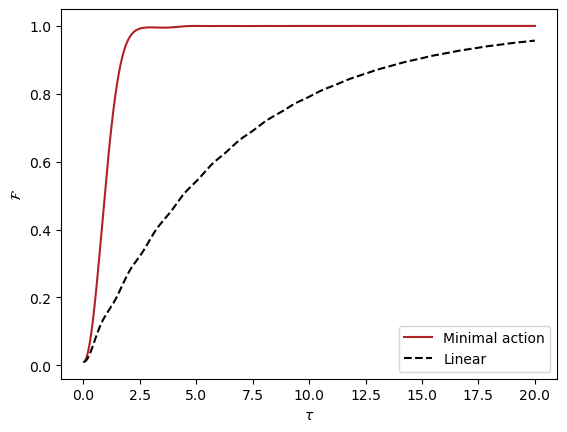

In [319]:
plt.figure()

# Axes label
plt.xlabel('$ \\tau $')
plt.ylabel('$ \\mathcal{F} $')
plt.plot(fidel_interval, fidel, color='firebrick', label='Minimal action')
plt.plot(fidel_interval, fidel_lin, color='black', linestyle='dashed', label='Linear')
plt.legend()
plt.show()